https://www.kaggle.com/datasets/anthonypino/melbourne-housing-market?select=Melbourne_housing_FULL.csv

Target feature = Price 
Categorical features  
Continuous features 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from scipy.stats import boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as smgt
from statsmodels.stats import stattools
from sklearn.preprocessing import StandardScaler,Normalizer,LabelEncoder,PolynomialFeatures,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV,StratifiedKFold,learning_curve,KFold,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,SGDRegressor
from sklearn.tree import DecisionTreeRegressor,export_graphviz
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel, RFE,SelectPercentile,f_regression,VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
df= pd.read_csv('Melbourne_housing_FULL.csv')

In [4]:
df.head(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [5]:
#Remove those redundant attributes 
df.drop(['Address','Date','Postcode','YearBuilt','Lattitude','Longtitude'],axis=1,inplace=True)

In [6]:
#Continuous features 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,34857.0,3.031012e+00,0.969933,1.0,2.0,3.0,4.0,16.0
Price,27247.0,1.050173e+06,641467.130105,85000.0,635000.0,870000.0,1295000.0,11200000.0
Distance,34856.0,1.118493e+01,6.788892,0.0,6.4,10.3,14.0,48.1
Bedroom2,26640.0,3.084647e+00,0.980690,0.0,2.0,3.0,4.0,30.0
Bathroom,26631.0,1.624798e+00,0.724212,0.0,1.0,2.0,2.0,12.0
Car,26129.0,1.728845e+00,1.010771,0.0,1.0,2.0,2.0,26.0
Landsize,23047.0,5.935990e+02,3398.841946,0.0,224.0,521.0,670.0,433014.0
BuildingArea,13742.0,1.602564e+02,401.267060,0.0,102.0,136.0,188.0,44515.0
Propertycount,34854.0,7.572888e+03,4428.090313,83.0,4385.0,6763.0,10412.0,21650.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Rooms          34857 non-null  int64  
 2   Type           34857 non-null  object 
 3   Price          27247 non-null  float64
 4   Method         34857 non-null  object 
 5   SellerG        34857 non-null  object 
 6   Distance       34856 non-null  float64
 7   Bedroom2       26640 non-null  float64
 8   Bathroom       26631 non-null  float64
 9   Car            26129 non-null  float64
 10  Landsize       23047 non-null  float64
 11  BuildingArea   13742 non-null  float64
 12  CouncilArea    34854 non-null  object 
 13  Regionname     34854 non-null  object 
 14  Propertycount  34854 non-null  float64
dtypes: float64(8), int64(1), object(6)
memory usage: 4.0+ MB


Missing values 

In [8]:
#simplificity, missing values > 40% of the dataset, remove them. Imputing them with mean, mode, median might impose a data skewness
df.isnull().sum()

Suburb               0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Distance             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
CouncilArea          3
Regionname           3
Propertycount        3
dtype: int64

In [9]:
df.dropna(inplace= True)

In [10]:
df.isnull().sum()

Suburb           0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Distance         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
CouncilArea      0
Regionname       0
Propertycount    0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9244 entries, 2 to 34856
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         9244 non-null   object 
 1   Rooms          9244 non-null   int64  
 2   Type           9244 non-null   object 
 3   Price          9244 non-null   float64
 4   Method         9244 non-null   object 
 5   SellerG        9244 non-null   object 
 6   Distance       9244 non-null   float64
 7   Bedroom2       9244 non-null   float64
 8   Bathroom       9244 non-null   float64
 9   Car            9244 non-null   float64
 10  Landsize       9244 non-null   float64
 11  BuildingArea   9244 non-null   float64
 12  CouncilArea    9244 non-null   object 
 13  Regionname     9244 non-null   object 
 14  Propertycount  9244 non-null   float64
dtypes: float64(8), int64(1), object(6)
memory usage: 1.1+ MB


Target Feature

In [12]:
df['Price_log'] = np.log1p(df['Price'])

In [13]:
df

,Suburb,Rooms,Type,Price,Method,SellerG,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,CouncilArea,Regionname,Propertycount,Price_log
2,Abbotsford,2,h,1035000.0,S,Biggin,2.5,2.0,1.0,0.0,156.0,79.0,Yarra City Council,Northern Metropolitan,4019.0,13.849913
4,Abbotsford,3,h,1465000.0,SP,Biggin,2.5,3.0,2.0,0.0,134.0,150.0,Yarra City Council,Northern Metropolitan,4019.0,14.197366
6,Abbotsford,4,h,1600000.0,VB,Nelson,2.5,3.0,1.0,2.0,120.0,142.0,Yarra City Council,Northern Metropolitan,4019.0,14.285515
11,Abbotsford,3,h,1876000.0,S,Nelson,2.5,4.0,2.0,0.0,245.0,210.0,Yarra City Council,Northern Metropolitan,4019.0,14.444653
14,Abbotsford,2,h,1636000.0,S,Nelson,2.5,2.0,1.0,2.0,256.0,107.0,Yarra City Council,Northern Metropolitan,4019.0,14.307765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34847,Wollert,3,h,500000.0,PI,Ray,25.5,3.0,2.0,2.0,383.0,118.0,Whittlesea City Council,Northern Metropolitan,2940.0,13.122365
34849,Wollert,3,h,570000.0,SP,RW,25.5,3.0,2.0,2.0,404.0,158.0,Whittlesea City Council,Northern Metropolitan,2940.0,13.253393
34853,Yarraville,2,h,888000.0,SP,Sweeney,6.3,2.0,2.0,1.0,98.0,104.0,Maribyrnong City Council,Western Metropolitan,6543.0,13.696728
34854,Yarraville,2,t,705000.0,S,Jas,6.3,2.0,1.0,2.0,220.0,120.0,Maribyrnong City Council,Western Metropolitan,6543.0,13.465955


<Axes: xlabel='Price', ylabel='Density'>

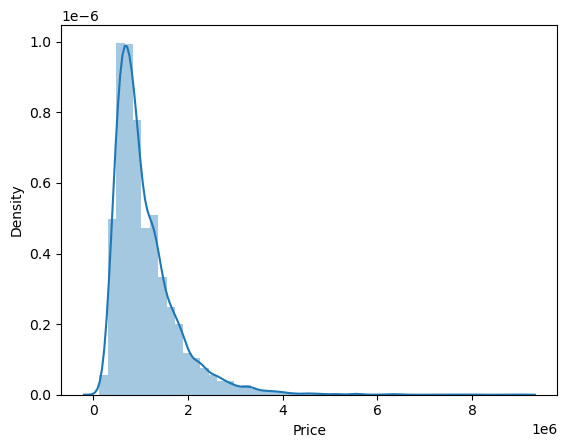

In [14]:
sns.distplot(df['Price'])


<Axes: xlabel='Price_log', ylabel='Density'>

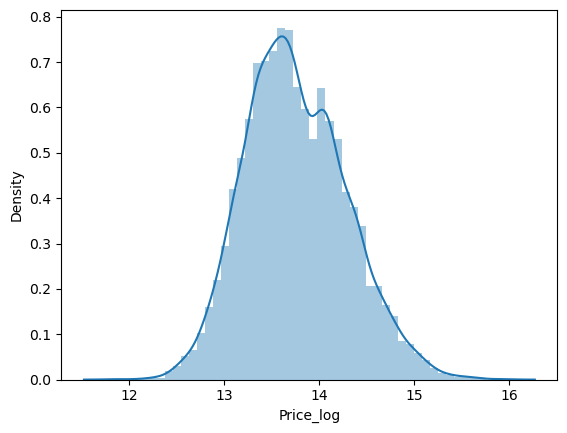

In [15]:
sns.distplot(df['Price_log'])

Exploratory Data Analysis (EDA) 

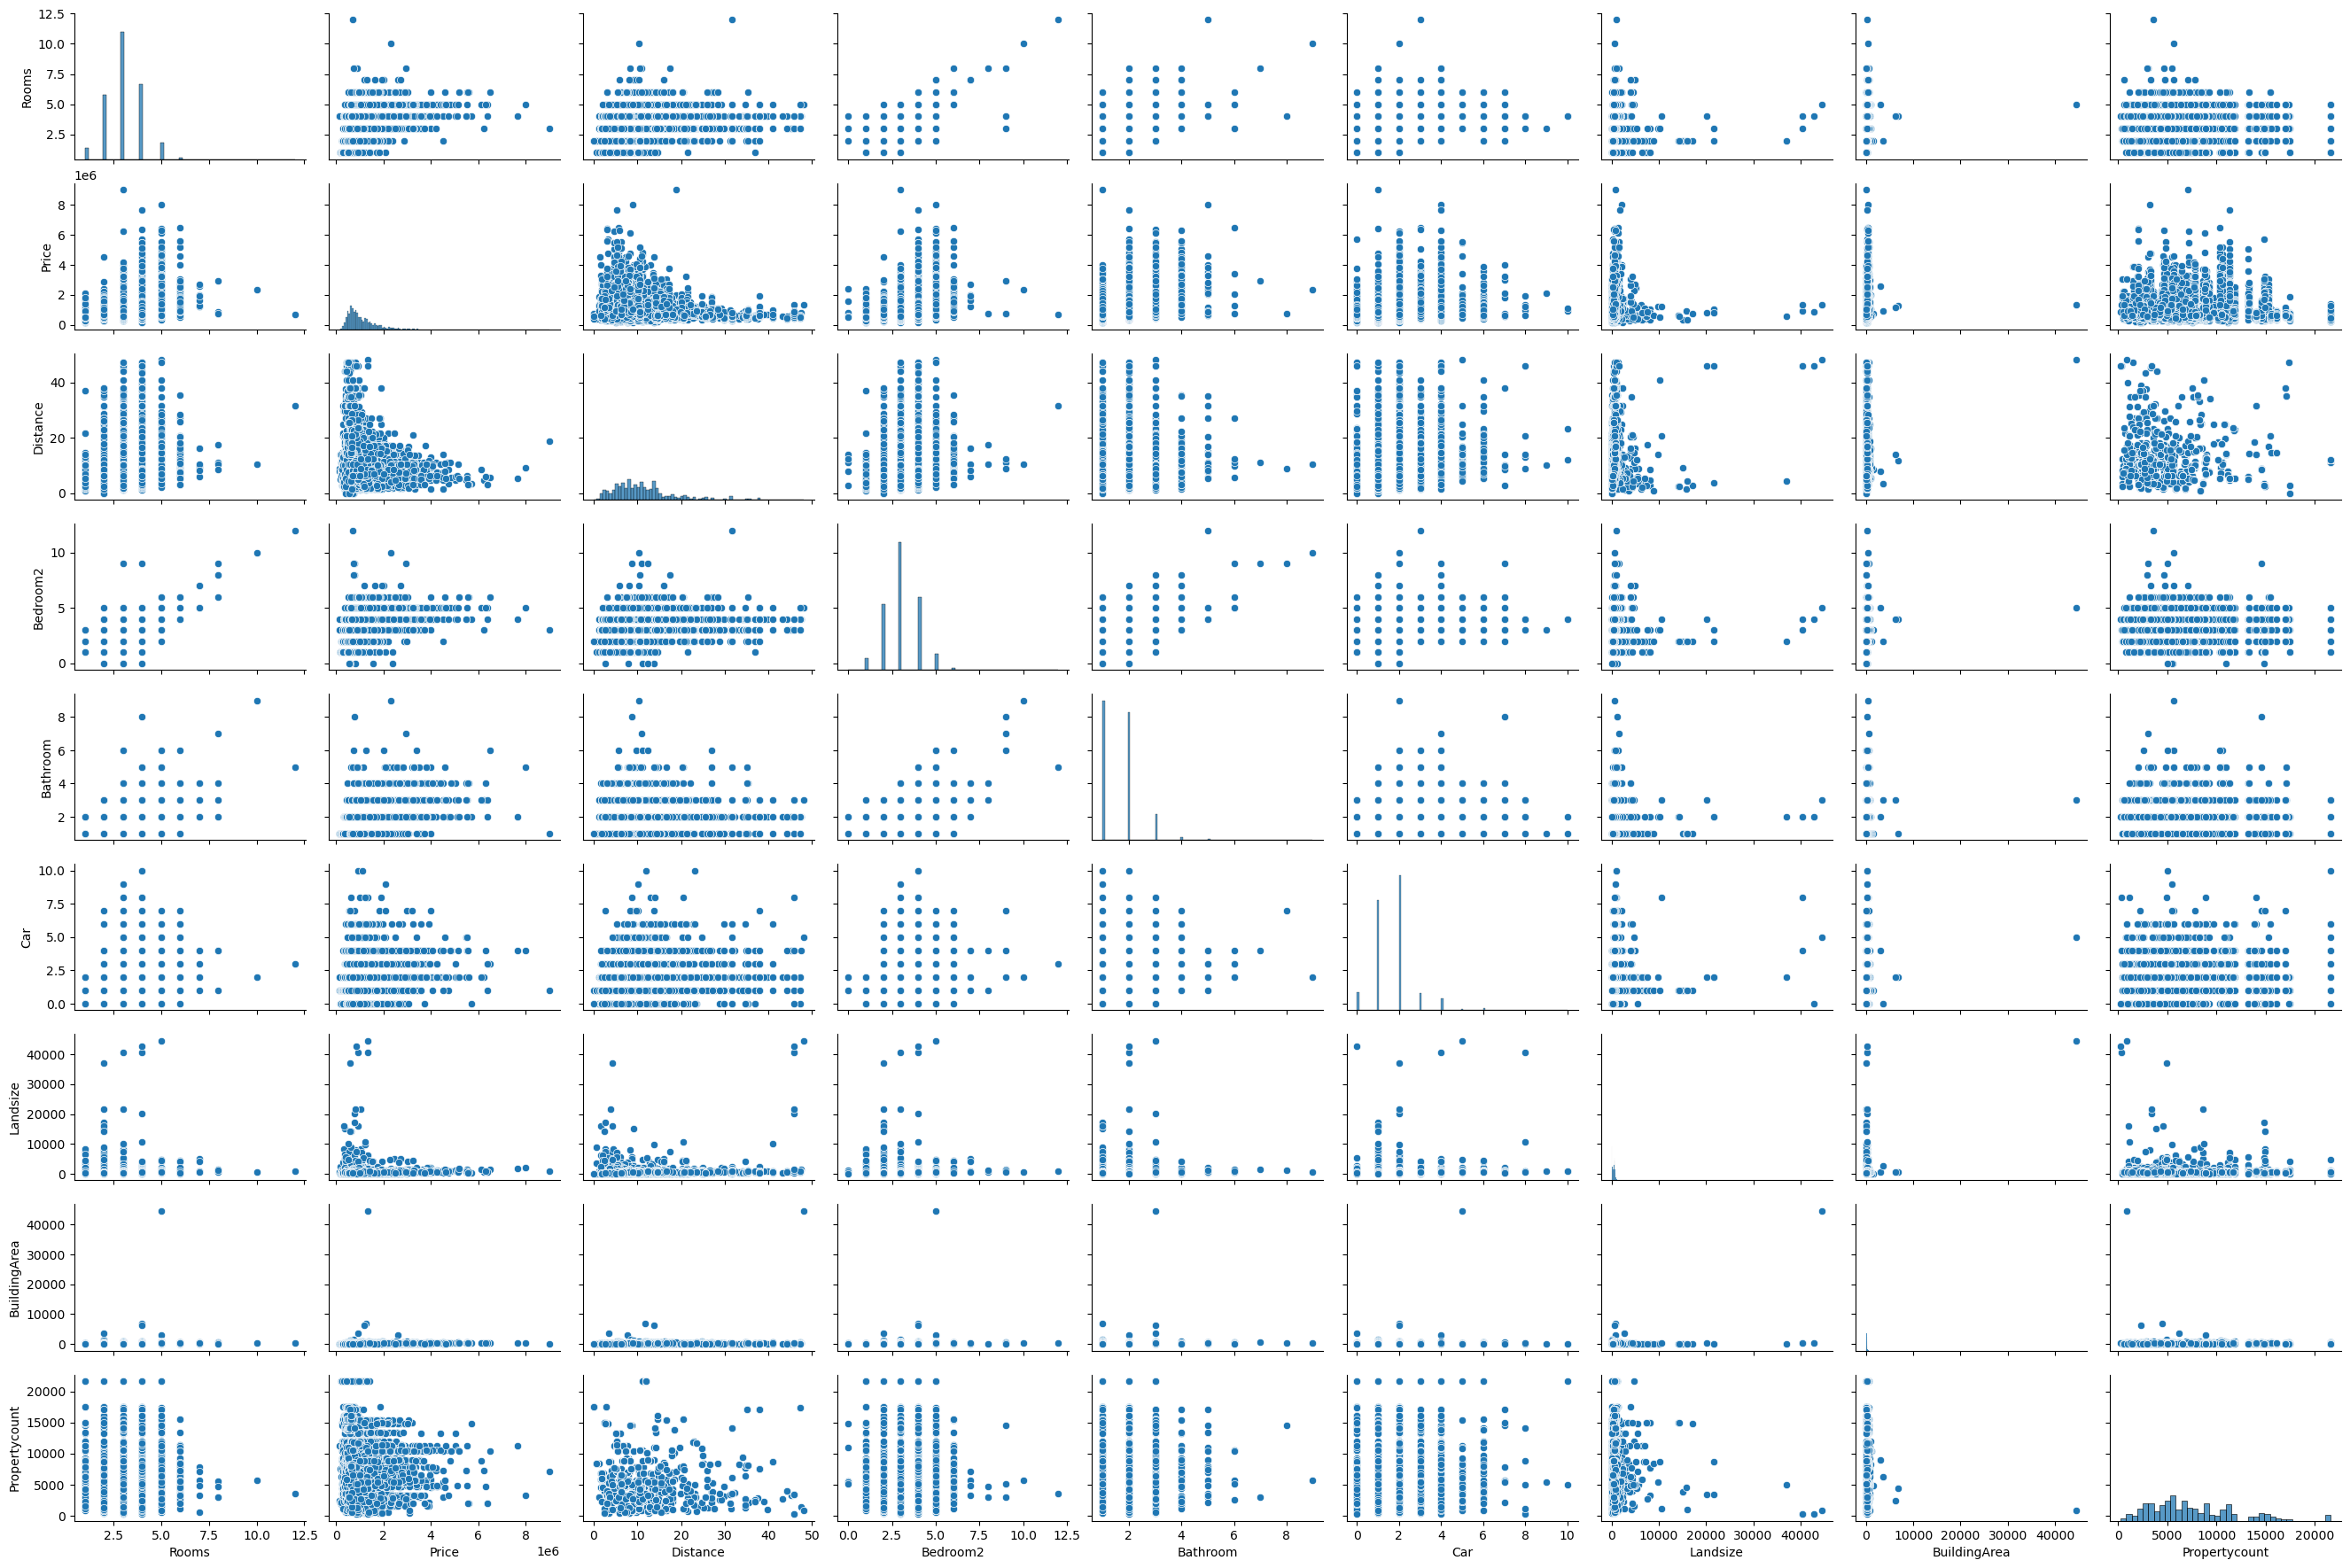

In [75]:
#Seaborn pairplot correlation
sns.pairplot(df, height = 2, aspect = 1.5)

MultiCollinearity Test 
VIF Analysis 
Variance Inflation Analysis : Run regression and find collinearity of features
1 : not correlated.
(1-5) : moderately correlated.
(>5) : highly correlated.

In [16]:
numeric_features = list(df.columns[df.dtypes != 'object'].values)
print("Numeric features :" ,numeric_features)
numeric_features.remove('Price')
numeric_features.remove('Price_log')
categoric_features = list(df.columns[df.dtypes == 'object'].values)
print("Categoric features :" ,categoric_features)

Numeric features : ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Propertycount', 'Price_log']
Categoric features : ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']


In [17]:
def calculate_vif(X):
    X['intercept'] = 1
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    vif['VIF Factor'] = round(vif['VIF Factor'],2)
    vif = vif[vif['features'] != 'intercept']
    vif.sort_values('VIF Factor',ascending=False,inplace=True)
    return vif
calculate_vif(df[numeric_features])

,VIF Factor,features
2,14.66,Bedroom2
0,14.49,Rooms
3,1.67,Bathroom
4,1.25,Car
5,1.20,Landsize
6,1.18,BuildingArea
1,1.15,Distance
7,1.01,Propertycount


In [18]:
le = LabelEncoder()
for feature in categoric_features:
    colname = 'le_' + feature
    df[colname] = le.fit_transform(df[feature])

encoded_features = ['le_' + x for x in categoric_features]

In [19]:
calculate_vif(df[encoded_features])

,VIF Factor,features
1,1.02,le_Type
4,1.02,le_CouncilArea
0,1.01,le_Suburb
2,1.01,le_Method
5,1.01,le_Regionname
3,1.00,le_SellerG


Correlation Map 

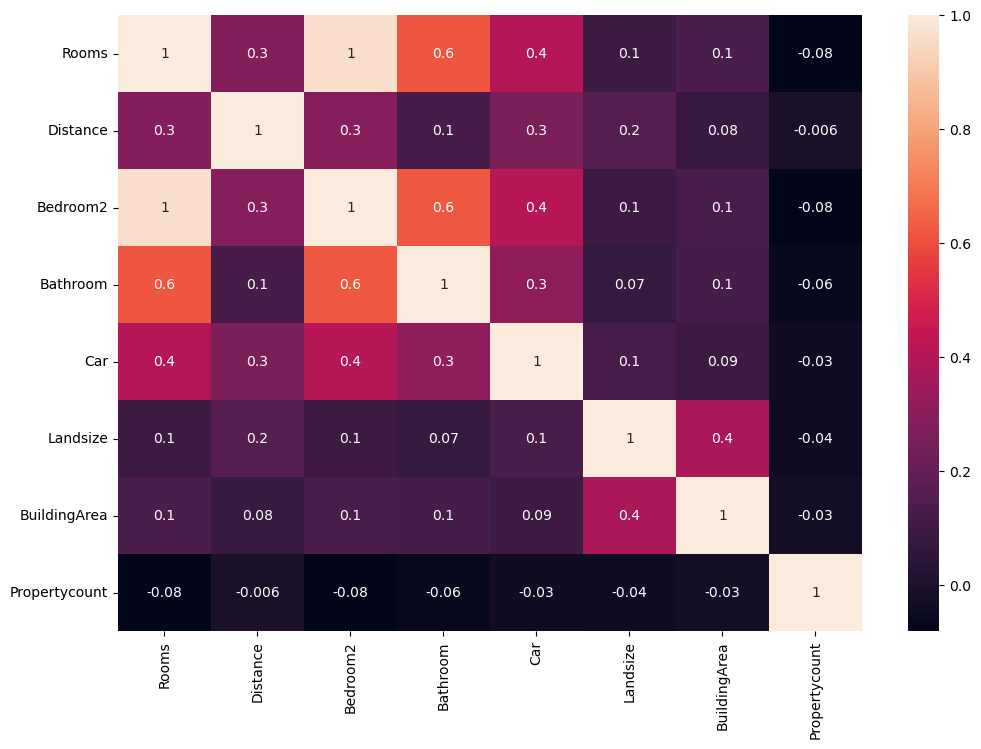

In [20]:
corr_matrix_1 = np.corrcoef(df[numeric_features],rowvar=False)
corr_matrix_1 = df[numeric_features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix_1,annot=True,fmt='.1g')
plt.show()

In [21]:
numeric_features.remove('Bedroom2')

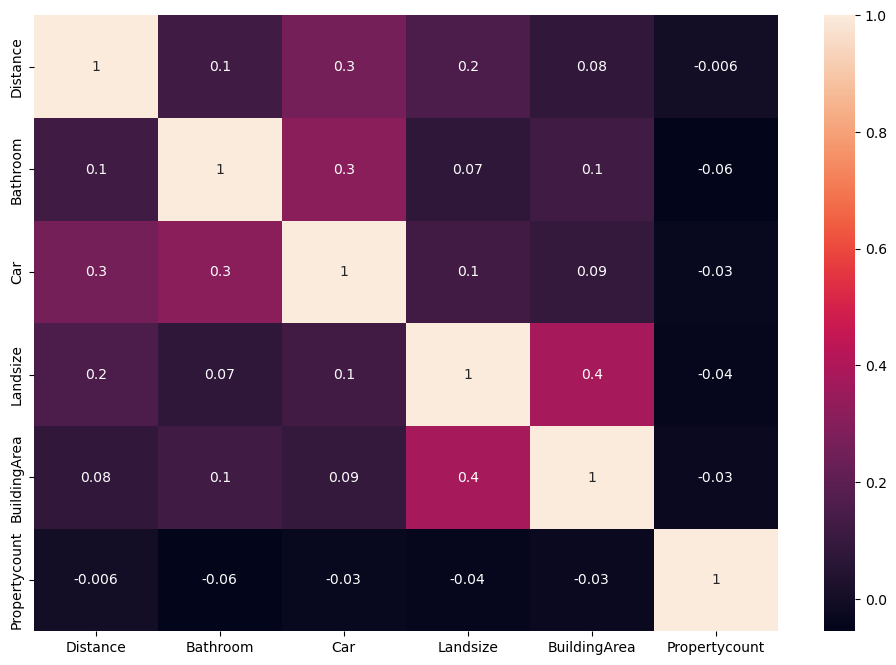

In [83]:
corr_matrix_1 = np.corrcoef(df[numeric_features],rowvar=False)
corr_matrix_1 = df[numeric_features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix_1,annot=True,fmt='.1g')
plt.show()

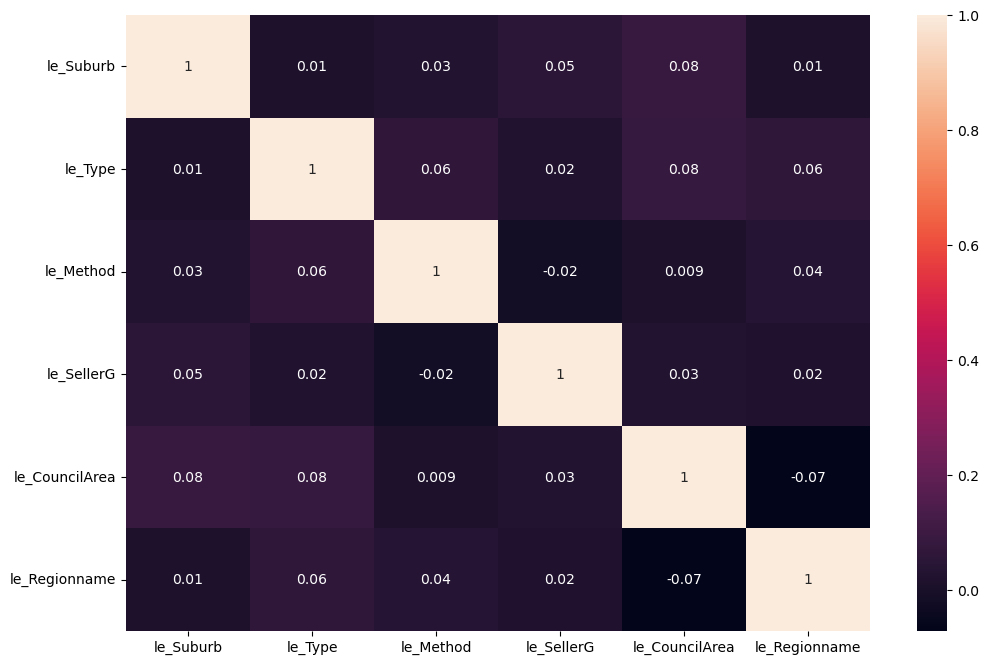

In [84]:
corr_matrix_2 = np.corrcoef(df[encoded_features],rowvar=False)
corr_matrix_2 = df[encoded_features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix_2,annot=True,fmt='.1g')
plt.show()

In [22]:
calculate_vif(df[numeric_features + encoded_features])

,VIF Factor,features
0,2.39,Rooms
2,1.68,Bathroom
8,1.51,le_Type
3,1.26,Car
4,1.20,Landsize
1,1.18,Distance
5,1.18,BuildingArea
6,1.05,Propertycount
11,1.05,le_CouncilArea
12,1.05,le_Regionname


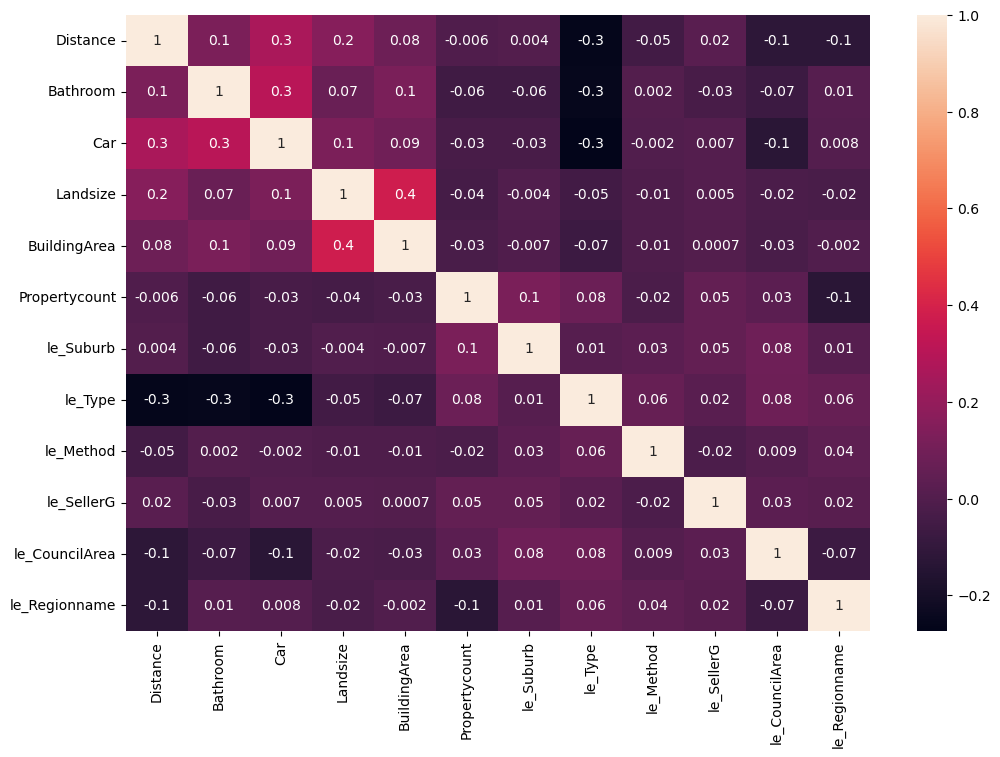

In [86]:
corr_matrix_3 = np.corrcoef(df[numeric_features + encoded_features],rowvar=False)
corr_matrix_3 = df[numeric_features + encoded_features].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix_3,annot=True,fmt='.1g')
plt.show()

In [23]:
print("Numeric features :" ,numeric_features)
print("Categoric features :" ,categoric_features)

Numeric features : ['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Propertycount']
Categoric features : ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9244 entries, 2 to 34856
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Suburb          9244 non-null   object 
 1   Rooms           9244 non-null   int64  
 2   Type            9244 non-null   object 
 3   Price           9244 non-null   float64
 4   Method          9244 non-null   object 
 5   SellerG         9244 non-null   object 
 6   Distance        9244 non-null   float64
 7   Bedroom2        9244 non-null   float64
 8   Bathroom        9244 non-null   float64
 9   Car             9244 non-null   float64
 10  Landsize        9244 non-null   float64
 11  BuildingArea    9244 non-null   float64
 12  CouncilArea     9244 non-null   object 
 13  Regionname      9244 non-null   object 
 14  Propertycount   9244 non-null   float64
 15  Price_log       9244 non-null   float64
 16  le_Suburb       9244 non-null   int32  
 17  le_Type         9244 non-null   

Linear Regression 
Assumptions

Bias vs Variance trade off
Handling of outlier data points
Linearity between response & predictor features
No perfect multicollinearity between the predictors (via VIF Factor or correlation)
Zero mean of the residuals and Homoscedasticity (constant variance)
Normality of residuals
No autocorrelation of residuals
Performance Measures

R2 increases whenever a new feature is added to the model.
R2_adj increases whenever an improving feature is added to the model.
High R2 doesn't mean good fit
Exceptions
Use Lars Regression for high dimensional data

In [25]:
def scale_data(X):
    return pd.DataFrame(StandardScaler().fit_transform(X),columns = X.columns.values)

In [26]:
def make_data(n_points, err = 1.0, random_state = 42):
    rnd_gen = np.random.RandomState(random_state)
    X = rnd_gen.rand(n_points, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rnd_gen.randn(n_points)
    return X, np.abs(y)

In [27]:
def set_poly_feature(X,y,degree,plot_type = 'reg'):
    poly = PolynomialFeatures(degree = degree)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly,y)
    y_pred = lr.predict(X_poly)
    if plot_type == 'reg':
        sns.regplot(x='X',y='y',data = dftemp,fit_reg=False)
        sns.lineplot(dftemp['X'],y_pred,c = 'r',lw = 1,label = 'degree ' + str(degree))
        plt.legend(loc='upper left')
    else:
        residuals = y_pred - y
        sns.scatterplot(x = y_pred,y = residuals)
        plt.axhline(y = 0, c = 'r', lw = 1)
        plt.title('Residual for degree ' + str(degree))

In [28]:
def plot_residuals(y_pred,residuals):
    print("Durbin-Watson test statistics is " + str(round(stattools.durbin_watson(residuals),2)))
    fig,ax = plt.subplots(1,3,figsize=(18,4))
    sns.scatterplot(x = y_pred,y = residuals,ax = ax[0])
    ax[0].axhline(y=0, c='r', lw=1)
    stats.probplot(residuals, plot = ax[1])
    smgt.plot_acf(residuals,ax = ax[2])
    plt.show()

In [29]:
def print_reg_result(estimator,X,y,y_pred):
    mse = round(mean_squared_error(y, y_pred),2)
    print("Mean Square Error (MSE): ", mse)

    rmse = round(np.sqrt(mse),2)
    print("Root Mean Square Error (RMSE):", rmse)

    mae = round(mean_absolute_error(y,y_pred),2)
    print("Mean Absolute Error :", mae)

    r_sq = round(estimator.score(X, y),2)
    print('R-square         :', r_sq)
    
    adj_r_sq = round(1 - (1 - r_sq) * (len(y) - 1) / (len(y_pred) - X.shape[1] - 1),2)
    print('R-square adj.    :',adj_r_sq)

In [30]:
X = df[numeric_features]
y = df['Price_log']

13.01 [ 0.28 -0.03  0.13  0.04  0.    0.   -0.  ]
Mean Square Error (MSE):  0.15
Root Mean Square Error (RMSE): 0.39
Mean Absolute Error : 0.31
R-square         : 0.47
R-square adj.    : 0.47
Durbin-Watson test statistics is 1.46


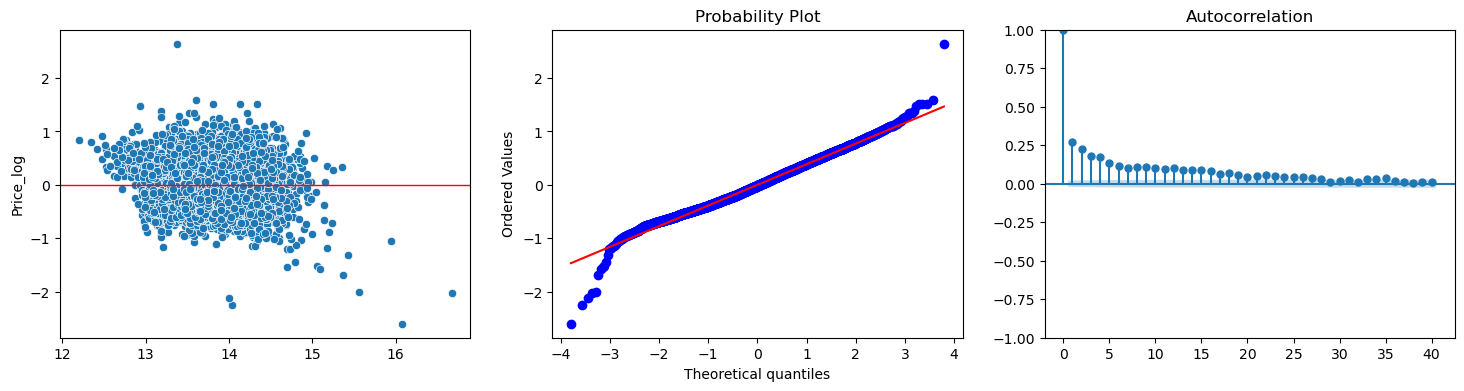

In [31]:
lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
residuals = y - y_pred
print(round(lr.intercept_,2),np.round(lr.coef_,2))
print_reg_result(lr,X,y,y_pred)
plot_residuals(y_pred,residuals)

13.75 [ 0.27 -0.23  0.09  0.04  0.02  0.01 -0.02]
Mean Square Error (MSE):  0.15
Root Mean Square Error (RMSE): 0.39
Mean Absolute Error : 0.31
R-square         : 0.47
R-square adj.    : 0.47
Durbin-Watson test statistics is 1.46


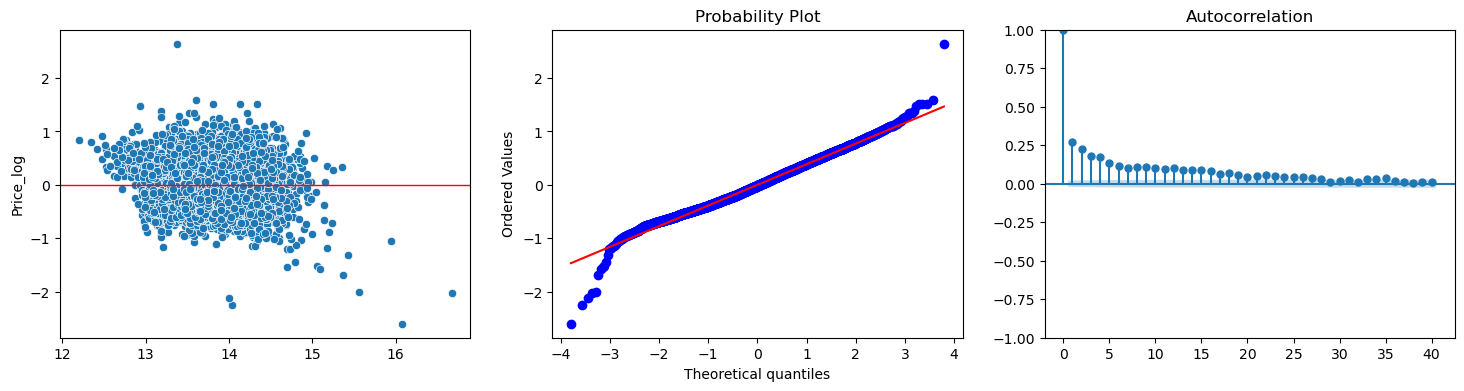

In [32]:
X = scale_data(df[numeric_features])
lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
residuals = y - y_pred
print(round(lr.intercept_,2),np.round(lr.coef_,2))
print_reg_result(lr,X,y,y_pred)
plot_residuals(y_pred,residuals)

In [33]:
df[numeric_features]

,Rooms,Distance,Bathroom,Car,Landsize,BuildingArea,Propertycount
2,2,2.5,1.0,0.0,156.0,79.0,4019.0
4,3,2.5,2.0,0.0,134.0,150.0,4019.0
6,4,2.5,1.0,2.0,120.0,142.0,4019.0
11,3,2.5,2.0,0.0,245.0,210.0,4019.0
14,2,2.5,1.0,2.0,256.0,107.0,4019.0
...,...,...,...,...,...,...,...
34847,3,25.5,2.0,2.0,383.0,118.0,2940.0
34849,3,25.5,2.0,2.0,404.0,158.0,2940.0
34853,2,6.3,2.0,1.0,98.0,104.0,6543.0
34854,2,6.3,1.0,2.0,220.0,120.0,6543.0


In [34]:
model = smf.ols('Price_log ~ Rooms + Distance + Bathroom + Car + Landsize + BuildingArea + Propertycount ', data = df)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_log   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     1182.
Date:                Sun, 02 Jul 2023   Prob (F-statistic):               0.00
Time:                        18:14:33   Log-Likelihood:                -4364.7
No. Observations:                9244   AIC:                             8745.
Df Residuals:                    9236   BIC:                             8802.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.0084      0.016    803.740

Residual Plots
Find heteroscedasticity
Use of Polynomial Features or Data Transformation
Do not expect perfect distribution in real life


In [35]:
N = 200 #number of points
X, y = make_data(200)
dftemp = pd.DataFrame({'X':X.ravel(), 'y':y})
print(dftemp.shape)
dftemp.head()

(200, 2)


,X,y
0,0.140280,5.158169
1,0.903858,9.236097
2,0.535815,8.720288
3,0.358392,7.104110
4,0.024342,3.823428


In [36]:
lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
print(round(lr.intercept_,2),np.round(lr.coef_,2))
print_reg_result(lr,X,y,y_pred)

3.24 [8.31]
Mean Square Error (MSE):  2.85
Root Mean Square Error (RMSE): 1.69
Mean Absolute Error : 1.41
R-square         : 0.69
R-square adj.    : 0.69


TypeError: lineplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

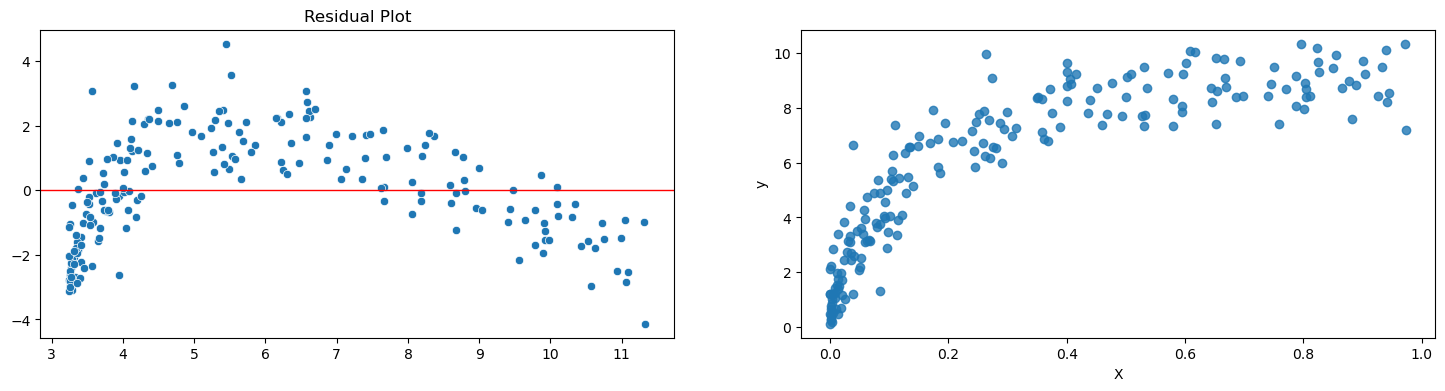

In [37]:
residuals = y - y_pred
fig,ax=plt.subplots(1,2,figsize=(18,4))
sns.scatterplot(x = y_pred,y = residuals,ax = ax[0])
ax[0].axhline(y = 0, c = 'r', lw = 1)
ax[0].set(title='Residual Plot')
sns.regplot(x='X',y='y',data = dftemp,fit_reg=False, ax = ax[1])
sns.lineplot(dftemp['X'],y_pred,c = 'r',lw = 1,ax = ax[1])
ax[1].set(title='Regression Plot')
plt.show()

TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given

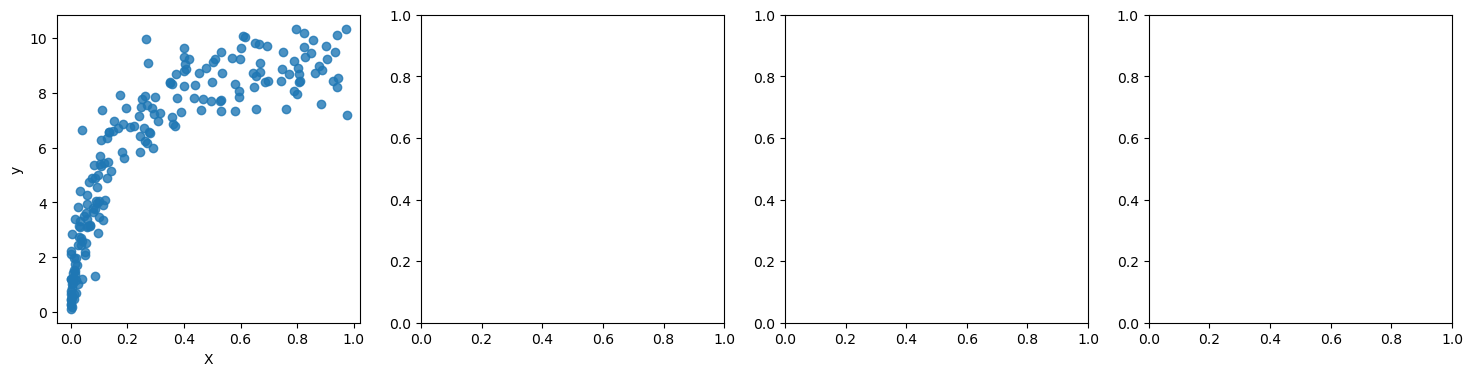

In [38]:
fig,ax = plt.subplots(1,4,figsize=(18,4))
plt.subplot(141)
set_poly_feature(X,y,2)
plt.subplot(142)
set_poly_feature(X,y,10)
plt.subplot(143)
set_poly_feature(X,y,30)
plt.subplot(144)
set_poly_feature(X,y,50)
plt.show()

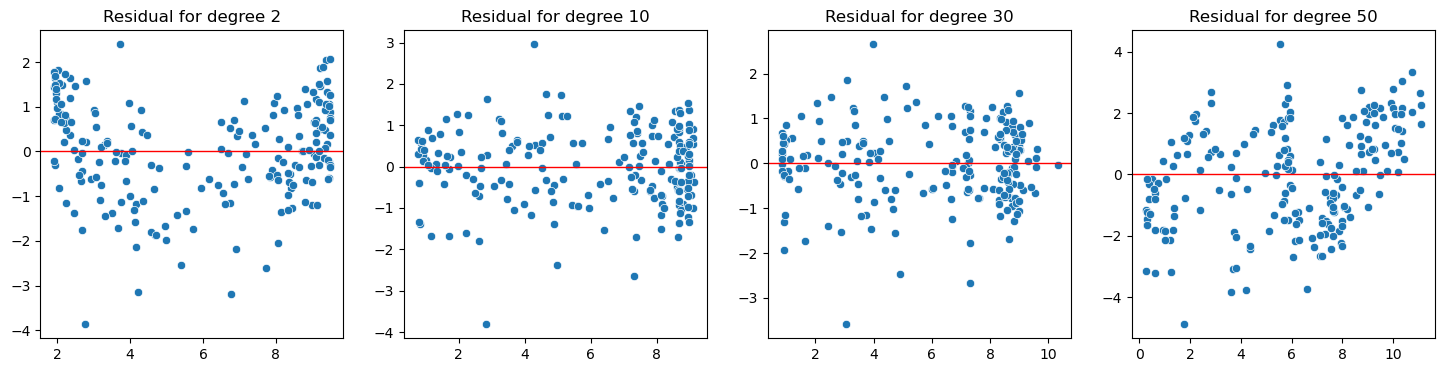

In [39]:
fig,ax = plt.subplots(1,4,figsize=(18,4))
plt.subplot(141)
set_poly_feature(X,y,2,'res')
plt.subplot(142)
set_poly_feature(X,y,10,'res')
plt.subplot(143)
set_poly_feature(X,y,30,'res')
plt.subplot(144)
set_poly_feature(X,y,50,'res')
plt.show()

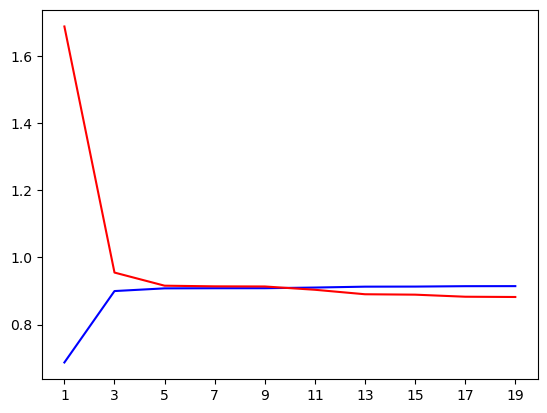

In [40]:
score = []
rmse = []
for degree in range(1,20,2):
    X_poly = PolynomialFeatures(degree = degree).fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly,y)
    y_pred = lr.predict(X_poly)
    score.append(lr.score(X_poly,y))
    rmse.append(np.sqrt(mean_squared_error(y,y_pred)))
plt.plot(score,c = 'b')
plt.plot(rmse,c='r')
plt.xticks(range(len(rmse)),range(1,20,2))
plt.show()

0.86 [    0.      57.98  -249.95   817.39 -2079.58  3857.63 -4651.11  3143.07
  -888.27]
Mean Square Error (MSE):  0.83
Root Mean Square Error (RMSE): 0.91
Mean Absolute Error : 0.72
R-square         : 0.91
R-square adj.    : 0.91
Durbin-Watson test statistics is 2.11


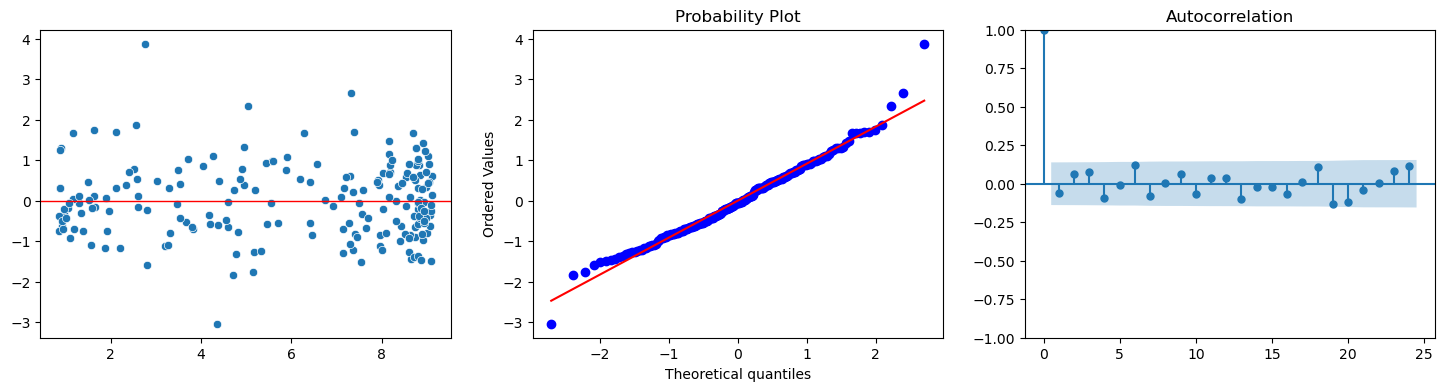

In [41]:
X_poly = PolynomialFeatures(degree = 8).fit_transform(X)
lr = LinearRegression()
lr.fit(X_poly,y)
y_pred = lr.predict(X_poly)
residuals = y - y_pred
print(round(lr.intercept_,2),np.round(lr.coef_,2))
print_reg_result(lr,X_poly,y,y_pred)
plot_residuals(y_pred,residuals)

In [42]:
X = scale_data(df[numeric_features + encoded_features])
y = df['Price_log']

13.75 [ 0.16 -0.25  0.12  0.02  0.02  0.01 -0.01 -0.05 -0.19 -0.01 -0.02 -0.05
  0.01]
Mean Square Error (MSE):  0.12
Root Mean Square Error (RMSE): 0.35
Mean Absolute Error : 0.28
R-square         : 0.57
R-square adj.    : 0.57
Durbin-Watson test statistics is 1.35


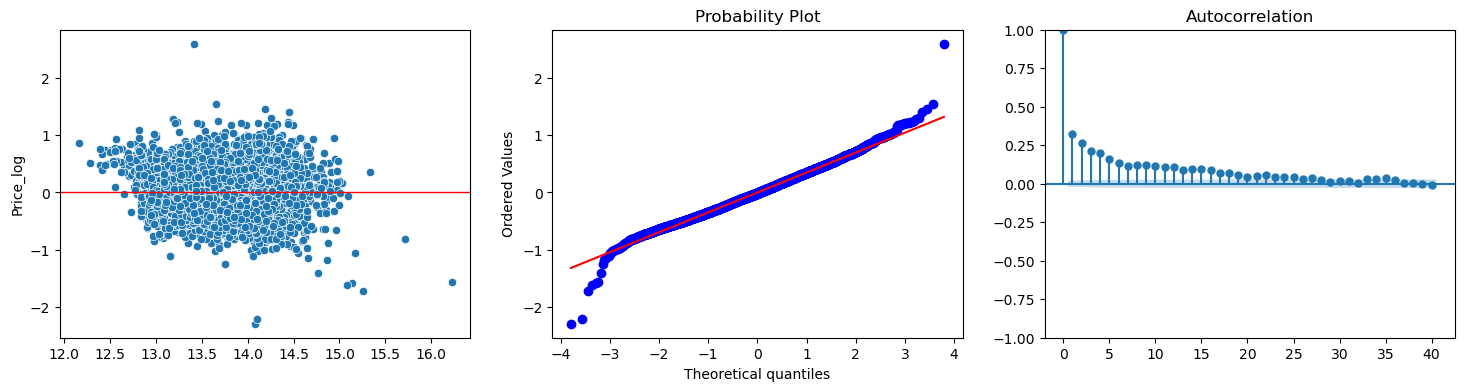

In [43]:
lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
residuals = y - y_pred
print(round(lr.intercept_,2),np.round(lr.coef_,2))
print_reg_result(lr,X,y,y_pred)
plot_residuals(y_pred,residuals)